# Notebook M06 - Plume problem

This is an implementation of a 2D viscous flow code. The energy equation (for temperature) is solved at the cell centers (unlike the example in the chapter 10 notebook, which is solved at the basic nodes.

This notebook puts all of the major function definitions into separate source files and contains only the high-level program code.

In [15]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
include("Grid.jl")
include("GridOperations.jl")
include("Markers.jl")
include("Stokes.jl")
include("StokesCylindrical.jl")

include("Temperature.jl")
include("TemperatureCylindrical.jl")

# note that we import pyplot last to avoid a name conflict with grid.
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Problem setup

- Lithosphere with initial geotherm set by plate cooling

In [16]:
# problem set-up
using SpecialFunctions
# function to define plate cooling solution
function plate_cooling(Tsurf,Tbtm,yL0,kappa,y,t)
   # y is a vector of y coordinates where we need the solution
    T = Tsurf .+ (Tbtm-Tsurf) .* (y/yL0)
    for n in 1:20 # note 20 is an index in a summation from 1 to Inf
        T += (Tbtm-Tsurf)*2/pi .* 1/n*exp(-kappa*n^2*pi^2*t/yL0^2)*sin(n*pi*y/yL0)
    end
    return T
end

function halfspace_cooling(Tsurf,Tmantle,kappa,y,t)
    if t == 0.0
        if y==0.0
            return Tsurf
        else
            return Tmantle
        end
    else
        T = Tsurf + (Tmantle-Tsurf)*erf(y/2/sqrt(kappa*t))         
        return T
    end
end

function halfspace_cooling_from_thickness(Tsurf,Tmantle,kappa,y,thickness)
    t = (thickness/2)^2/kappa
    return halfspace_cooling(Tsurf,Tmantle,kappa,y,t)
end

# function to compute solidus and liquidus

# function to compute melt fraction

# function to compute viscosity
function viscosity(eta0::Float64,T::Float64,E::Float64 ; visc_max=1.0e25)
   # E should be given in J/mol/K
   # Expect all temperatures in kelvin.
   Tref = 1350.0+273.0
   R = 8.314 #J/mol/K
   viscosity = eta0*exp(E/R/Tref*(Tref/T-1))
   if viscosity > visc_max
      viscosity = visc_max
   end
   return viscosity
end

struct Materials
    # 1 - ambient mantle
    # 2 - eclogite
    alpha::Vector{Float64}
    rho0::Vector{Float64}
    Hr::Vector{Float64}
    Cp::Vector{Float64}
    kThermal::Vector{Float64}
    eta::Vector{Float64}
    Ea::Vector{Float64}
    function Materials()
         new([3e-5,3e-5],[3300.,3300.],[0.0,0.0],[1000.,1000.],[3.0,3.0],[1e21,1e21],[3e5,3e5])
    end
end

function update_marker_properties!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    eta = markers.scalarFields["eta"]
    for i in 1:markers.nmark                
        # re-compute density using the current temperature value
        # assume reference temperature is 273.0
        # markers.scalars[rho,i] = materials.rho0[mmat[i]] # don't update density - for comparison with gerya
        markers.scalars[rho,i] = materials.rho0[mmat[i]]*(1.0-materials.alpha[mmat[i]]*(markers.scalars[T,i]-273.0)) 
        markers.scalars[eta,i] = viscosity(materials.eta[mmat[i]],markers.scalars[T,i],materials.Ea[mmat[i]])
    end
end

function initial_conditions!(markers::Markers,materials::Materials)
    # Define geometric properties
    lithosphere_thickness = 1.5e5
    mantle_temperature = 1350.0
    
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-0)^2 + (my-2.85e6)^2)^0.5 
        
        # define initial cmb hot layer geometry
        h = 150e3 + (113e3-150e3)*(mx-0.0)/5e5
                
        # set material - eclogite at cmb
        if my > 2.85e6-h
           markers.integers[material,i] = 2
        else
           markers.integers[material,i] = 1
        end
                
        if my < lithosphere_thickness
            markers.scalars[T,i] = plate_cooling(273.0,1350.0+273.0,1.5e5,1e-6,my,100e6*3.15e7)
        else
            markers.scalars[T,i] = halfspace_cooling_from_thickness(2500.0+273.0,1350.0+273.0,1e-6,2.85e6-my,h)
        end
        ind = markers.integers[material,i]
        markers.scalars[eta,i] = viscosity(materials.eta[ind],markers.scalars[T,i],materials.Ea[ind])
        markers.scalars[alpha,i] = materials.alpha[ind]            
        markers.scalars[cp,i] = materials.Cp[ind]  
        markers.scalars[Hr,i] = materials.Hr[ind]  
    end
    update_marker_properties!(markers,materials)
end

initial_conditions! (generic function with 1 method)

In [17]:
# plotting routine
function plume_plots(grid::CartesianGrid,vx,vy,rho,T)
    # make some diagnostic plots using pyplot
    fig, (ax1,ax2,ax3,ax4) = subplots(1,4)
    ax1.pcolor(grid.xc,grid.yc,rho)
    ax1.invert_yaxis()
    ax1.set_title("Density")
    ax1.set_aspect("equal")
    ax2.pcolor(grid.xc,grid.yc,T)
    ax2.invert_yaxis()
    ax2.set_title("Temperature")
        ax2.set_aspect("equal")

    ax3.pcolor(grid.xc,grid.yc,vx)
    ax3.invert_yaxis()
    ax3.set_title("vx")
        ax3.set_aspect("equal")

    ax4.pcolor(grid.xc,grid.yc,vy)
    ax4.invert_yaxis()
    ax4.set_title("vy")
        ax4.set_aspect("equal")

    fig.show()
end


plume_plots (generic function with 1 method)

# i2vis procedure

0. Set up the Eulerian grid and Lagrangian markers. Distribute the markers within the domain and assign initial conditions.
1. Compute density and viscosity at the basic nodes. Compute cell center viscosity via averaging.
2. Assemble and solve the Stokes equations.
3. Compute the maximum timestep from the velocity field and CFL number.
3. Transfer temperature from markers to basic nodes.
4. Compute the new temperature solution.
5. If the maximum temperature change exceeds a specified value, reduce the timstep and repeat previous step.
6. Compute the subgrid temperature changes and update the temperature on the markers.
7. Move the markers using 4th order Runge-Kutta

TO DO:
1. Calculate rhox (rho at vx points) -> (optionally) pass to Stokes.jl (Max)
3. Add free-surface stabilization terms to Stokes.jl (Lucy)
4. Add functionality for shear heating (Max)
5. Add functionality for adiabatic heating (Uthkarsh)

Creating Markers...
  0.003310 seconds (19 allocations: 39.978 MiB)
Initial condition...
  0.757718 seconds (14.31 M allocations: 219.290 MiB, 3.69% gc time)
Trying with timestep 0.024006835227809487 Myr
dTmax=0.27118137708424683 dt=0.024006835227809487
Writing visualization fle plume/viz.0000.vtr
Min/Max velocity: -3.4725423673477687e-9 1.3639906352135179e-9
Finished Step 1 time=0.024006835227809487 Myr
Trying with timestep 0.02024195774415223 Myr
dTmax=0.23498845627017317 dt=0.02024195774415223
Min/Max velocity: -5.39074770224139e-9 1.7925731328515007e-9
Finished Step 2 time=0.04424879297196171 Myr
Trying with timestep 0.016430933581115244 Myr
dTmax=0.22193466398448436 dt=0.016430933581115244
Min/Max velocity: -8.665380648337316e-9 2.558701744327173e-9
Finished Step 3 time=0.06067972655307696 Myr
Trying with timestep 0.011036117134378352 Myr
dTmax=0.17649158069571058 dt=0.011036117134378352
Min/Max velocity: -1.4433433951472929e-8 4.329367131122006e-9
Finished Step 4 time=0.071715843

Trying with timestep 0.0007690455521649378 Myr
dTmax=0.07042053349277921 dt=0.0007690455521649378
Min/Max velocity: -2.071256602308691e-7 4.367382790692138e-8
Finished Step 47 time=0.1359578050583237 Myr
found nan values
Trying with timestep 0.000762636219517156 Myr
dTmax=0.0734177441781867 dt=0.000762636219517156
Min/Max velocity: -2.0886638172079724e-7 4.398266601269929e-8
Finished Step 48 time=0.13672044127784083 Myr
found nan values
Trying with timestep 0.0007568034848800237 Myr
dTmax=0.07639919663688488 dt=0.0007568034848800237
Min/Max velocity: -2.104761287734136e-7 4.426139339907108e-8
Finished Step 49 time=0.13747724476272086 Myr
found nan values
Trying with timestep 0.0007512017979798612 Myr
dTmax=0.07761095144360297 dt=0.0007512017979798612
Min/Max velocity: -2.1204564228698288e-7 4.452417096067083e-8
Finished Step 50 time=0.13822844656070074 Myr
found nan values
Trying with timestep 0.0007458286237469408 Myr
dTmax=0.07678507900300247 dt=0.0007458286237469408
Min/Max velocity

Min/Max velocity: -2.456506874801635e-7 4.85197054979483e-8
Finished Step 93 time=0.16754491307879857 Myr
Trying with timestep 0.0006477278394821089 Myr
dTmax=0.07670099016559107 dt=0.0006477278394821089
Min/Max velocity: -2.4591974905251605e-7 4.847518817756178e-8
Finished Step 94 time=0.16819264091828068 Myr
found nan values
Trying with timestep 0.0006476626497438168 Myr
dTmax=0.0758193611909519 dt=0.0006476626497438168
Min/Max velocity: -2.459445018217053e-7 4.8620930016206586e-8
Finished Step 95 time=0.16884030356802449 Myr
Trying with timestep 0.0006479544324076891 Myr
dTmax=0.07475215189560913 dt=0.0006479544324076891
Min/Max velocity: -2.4583374967878125e-7 4.855366525963863e-8
Finished Step 96 time=0.16948825800043216 Myr
Trying with timestep 0.0006469430452003012 Myr
dTmax=0.073316890154274 dt=0.0006469430452003012
Min/Max velocity: -2.462180696145375e-7 4.84725753554068e-8
Finished Step 97 time=0.17013520104563248 Myr
Trying with timestep 0.0006489162746681392 Myr
dTmax=0.071

Trying with timestep 0.0007298163852090011 Myr
dTmax=0.10850634473990795 dt=0.0007298163852090011
Min/Max velocity: -2.1825910046422463e-7 4.343106648989133e-8
Finished Step 141 time=0.19982104591097846 Myr
found nan values
Trying with timestep 0.0007163955604847919 Myr
dTmax=0.10782523156058232 dt=0.0007163955604847919
Min/Max velocity: -2.2234792693575067e-7 4.410320849150975e-8
Finished Step 142 time=0.20053744147146324 Myr
found nan values
Trying with timestep 0.0007277397944129327 Myr
dTmax=0.1108779585438242 dt=0.0007277397944129327
Min/Max velocity: -2.1888189839648253e-7 4.418138662768866e-8
Finished Step 143 time=0.2012651812658762 Myr
found nan values
Trying with timestep 0.0007297721311857642 Myr
dTmax=0.11253324768449602 dt=0.0007297721311857642
Min/Max velocity: -2.182723358878464e-7 4.334722947372152e-8
Finished Step 144 time=0.20199495339706194 Myr
found nan values
Trying with timestep 0.0007267821166624162 Myr
dTmax=0.11358634491534758 dt=0.0007267821166624162
Min/Max v

Min/Max velocity: -1.5205755621301767e-7 2.8894043811982318e-8
Finished Step 188 time=0.2399192735796029 Myr
found nan values
Trying with timestep 0.0010726791327370707 Myr
dTmax=0.23549212395300856 dt=0.0010726791327370707
Min/Max velocity: -1.4849647287658455e-7 2.5849065482273676e-8
Finished Step 189 time=0.24099195271234 Myr
found nan values
Trying with timestep 0.0010895720722771036 Myr
dTmax=0.24117642199280453 dt=0.0010895720722771036
Min/Max velocity: -1.4619415437738727e-7 2.6225383484554903e-8
Finished Step 190 time=0.24208152478461709 Myr
found nan values
Trying with timestep 0.0011217891947721801 Myr
dTmax=0.24887383020359266 dt=0.0011217891947721801
Min/Max velocity: -1.419955446906565e-7 2.580506286985238e-8
Finished Step 191 time=0.24320331397938927 Myr
found nan values
Trying with timestep 0.0011487224163073107 Myr
dTmax=0.25475212925675805 dt=0.0011487224163073107
Min/Max velocity: -1.3866628306237826e-7 2.8084376145206642e-8
Finished Step 192 time=0.24435203639569658 

Finished Step 235 time=0.3272515765053519 Myr
found nan values
Trying with timestep 0.002444447728784158 Myr
dTmax=0.8098689401745105 dt=0.002444447728784158
Min/Max velocity: -6.51636219764882e-8 1.756277355306414e-8
Finished Step 236 time=0.3296960242341361 Myr
Trying with timestep 0.002490593625716036 Myr
dTmax=0.8265411471825246 dt=0.002490593625716036
Min/Max velocity: -6.395626572519676e-8 1.6040559524099286e-8
Finished Step 237 time=0.3321866178598521 Myr
Trying with timestep 0.0025864184648658134 Myr
dTmax=0.8603196501608181 dt=0.0025864184648658134
Min/Max velocity: -6.158673466941582e-8 1.5829429098310373e-8
Finished Step 238 time=0.33477303632471794 Myr
found nan values
Trying with timestep 0.00277484027380973 Myr
dTmax=0.9249060139868561 dt=0.00277484027380973
Min/Max velocity: -5.74047700126076e-8 1.558067338807053e-8
Finished Step 239 time=0.33754787659852764 Myr
Trying with timestep 0.002878250623362844 Myr
dTmax=0.9632074863652633 dt=0.002878250623362844
Min/Max velocit

Min/Max velocity: -1.9705616562097322e-8 5.830338625796923e-9
Finished Step 282 time=0.6102499442975313 Myr
found nan values
Trying with timestep 0.007671360539524224 Myr
dTmax=2.9293164378418624 dt=0.007671360539524224
Min/Max velocity: -2.0764122207409e-8 5.756926143487195e-9
Finished Step 283 time=0.6179213048370554 Myr
found nan values
Trying with timestep 0.00732313586455203 Myr
dTmax=2.8034727744457086 dt=0.00732313586455203
Min/Max velocity: -2.17514833380075e-8 5.697391155808649e-9
Finished Step 284 time=0.6252444407016075 Myr
found nan values
Trying with timestep 0.006913954165802074 Myr
dTmax=2.6578708915185416 dt=0.006913954165802074
Min/Max velocity: -2.3038779824090694e-8 5.6351594192217005e-9
Finished Step 285 time=0.6321583948674097 Myr
Trying with timestep 0.006620481885466534 Myr
dTmax=2.558217640518251 dt=0.006620481885466534
Min/Max velocity: -2.4060041322587775e-8 5.58265193931533e-9
Finished Step 286 time=0.6387788767528761 Myr
Trying with timestep 0.00623154813300

dTmax=2.295360576217945 dt=0.005459382670822961
Min/Max velocity: -2.9177120810944065e-8 5.683675091080156e-9
Finished Step 331 time=0.8811720716733292 Myr
Trying with timestep 0.005629704677147396 Myr
dTmax=2.3674331948163854 dt=0.005629704677147396
Min/Max velocity: -2.8294391424540716e-8 5.6587863347624035e-9
Finished Step 332 time=0.8868017763504766 Myr
Trying with timestep 0.005903299863272618 Myr
dTmax=2.486569074654426 dt=0.005903299863272618
Min/Max velocity: -2.698305548237402e-8 5.554855950132908e-9
Finished Step 333 time=0.8927050762137493 Myr
Trying with timestep 0.0061551434591656 Myr
dTmax=2.598494326188984 dt=0.0061551434591656
Min/Max velocity: -2.5879017897230633e-8 5.435487245101663e-9
Finished Step 334 time=0.8988602196729149 Myr
Trying with timestep 0.006462936931911094 Myr
dTmax=2.73352833810236 dt=0.006462936931911094
Min/Max velocity: -2.4646545280872293e-8 5.257489352948225e-9
Finished Step 335 time=0.9053231566048259 Myr
Trying with timestep 0.00683060429799387

Trying with timestep 0.001671227000099549 Myr
dTmax=0.7443112469043172 dt=0.001671227000099549
Min/Max velocity: -9.531264617570226e-8 2.4502470655413806e-8
Finished Step 379 time=1.1526094727944167 Myr
found nan values
Trying with timestep 0.0017107607966899837 Myr
dTmax=0.7622200585246901 dt=0.0017107607966899837
Min/Max velocity: -9.311007596618097e-8 2.4253649730803897e-8
Finished Step 380 time=1.154320233591107 Myr
found nan values
Trying with timestep 0.0016854767058623935 Myr
dTmax=0.7512801056550416 dt=0.0016854767058623935
Min/Max velocity: -9.450683428951133e-8 2.3871879740706144e-8
Finished Step 381 time=1.1560057102969692 Myr
found nan values
Trying with timestep 0.0017061843313105002 Myr
dTmax=0.7607592030512933 dt=0.0017061843313105002
Min/Max velocity: -9.335982333012081e-8 2.3636911742838538e-8
Finished Step 382 time=1.1577118946282798 Myr
found nan values
Trying with timestep 0.0017215393189889596 Myr
dTmax=0.7678617395347374 dt=0.0017215393189889596
Min/Max velocity: 

Finished Step 425 time=1.2634290954712177 Myr
found nan values
Trying with timestep 0.0032954523597412497 Myr
dTmax=1.488470272847053 dt=0.0032954523597412497
Min/Max velocity: -4.833602502822495e-8 9.49941873598049e-9
Finished Step 426 time=1.266724547830959 Myr
found nan values
Trying with timestep 0.0031966500392687017 Myr
dTmax=1.4445788428472497 dt=0.0031966500392687017
Min/Max velocity: -4.9829998837225434e-8 9.545398082519548e-9
Finished Step 427 time=1.2699211978702278 Myr
found nan values
Trying with timestep 0.003243401134326693 Myr
dTmax=1.4660190554166093 dt=0.003243401134326693
Min/Max velocity: -4.911173830887739e-8 9.61572958227481e-9
Finished Step 428 time=1.2731645990045544 Myr
found nan values
Trying with timestep 0.003283961424932826 Myr
dTmax=1.4845387701134314 dt=0.003283961424932826
Min/Max velocity: -4.850515798705733e-8 9.706633119349443e-9
Finished Step 429 time=1.276448560429487 Myr
found nan values
Trying with timestep 0.0032097624661468786 Myr
dTmax=1.451278

Min/Max velocity: -4.156524957846447e-8 9.191085182771378e-9
Finished Step 472 time=1.4451360286268864 Myr
found nan values
Trying with timestep 0.003762977811144642 Myr
dTmax=1.7659933556728902 dt=0.003762977811144642
Min/Max velocity: -4.233058915947279e-8 9.766958957936801e-9
Finished Step 473 time=1.4488990064380312 Myr
found nan values
Trying with timestep 0.0036791113560035492 Myr
dTmax=1.7280797207774867 dt=0.0036791113560035492
Min/Max velocity: -4.329552773113246e-8 1.0404636653730929e-8
Finished Step 474 time=1.4525781177940345 Myr
found nan values
Trying with timestep 0.0036034453897129514 Myr
dTmax=1.7000198263858692 dt=0.0036034453897129514
Min/Max velocity: -4.42046570747295e-8 1.1038121769441045e-8
Finished Step 475 time=1.4561815631837474 Myr
found nan values
Trying with timestep 0.0035315549113997253 Myr
dTmax=1.6641714446684546 dt=0.0035315549113997253
Min/Max velocity: -4.5104513942455477e-8 1.1748417196613312e-8
Finished Step 476 time=1.4597131180951475 Myr
found na

Trying with timestep 0.0036845637218298256 Myr
dTmax=1.8535043055899223 dt=0.0036845637218298256
Min/Max velocity: -4.32314596151597e-8 5.666451768712356e-9
Finished Step 519 time=1.601692196180187 Myr
found nan values
Trying with timestep 0.0036826554684531985 Myr
dTmax=1.8596558862843722 dt=0.0036826554684531985
Min/Max velocity: -4.3253860999025565e-8 5.869378943074067e-9
Finished Step 520 time=1.6053748516486404 Myr
found nan values
Trying with timestep 0.00370503053698104 Myr
dTmax=1.8479893475264362 dt=0.00370503053698104
Min/Max velocity: -4.299264638978363e-8 6.085917535567363e-9
Finished Step 521 time=1.6090798821856214 Myr
found nan values
Trying with timestep 0.0037484323009557546 Myr
dTmax=1.863908277654673 dt=0.0037484323009557546
Min/Max velocity: -4.2494849833398714e-8 6.166943316556409e-9
Finished Step 522 time=1.6128283144865774 Myr
found nan values
Trying with timestep 0.0037598406493760264 Myr
dTmax=1.8850363541430397 dt=0.0037598406493760264
Min/Max velocity: -4.236

Finished Step 565 time=1.776182982763391 Myr
found nan values
Trying with timestep 0.004112868636099553 Myr
dTmax=2.070587211518159 dt=0.004112868636099553
Min/Max velocity: -3.872943238246436e-8 4.899757057730412e-9
Finished Step 566 time=1.7802958513994904 Myr
found nan values
Trying with timestep 0.0041089214622623835 Myr
dTmax=2.054663990694735 dt=0.0041089214622623835
Min/Max velocity: -3.876663723138457e-8 4.841690187901608e-9
Finished Step 567 time=1.7844047728617527 Myr
found nan values
Trying with timestep 0.004106123535849116 Myr
dTmax=2.04839465785858 dt=0.004106123535849116
Min/Max velocity: -3.879305294861978e-8 4.79226699190822e-9
Finished Step 568 time=1.788510896397602 Myr
found nan values
Trying with timestep 0.004084026789705271 Myr
dTmax=2.033121530218523 dt=0.004084026789705271
Min/Max velocity: -3.900294389382885e-8 4.745778134283732e-9
Finished Step 569 time=1.7925949231873073 Myr
found nan values
Trying with timestep 0.004072812043229909 Myr
dTmax=2.0260850392869

Min/Max velocity: -2.7741746519113604e-8 4.9228954456958544e-9
Finished Step 612 time=1.995876132613894 Myr
found nan values
Trying with timestep 0.004931464759544695 Myr
dTmax=2.246878266142403 dt=0.004931464759544695
Min/Max velocity: -2.737204570197672e-8 4.929585093030378e-9
Finished Step 613 time=2.0008075973734387 Myr
found nan values
Trying with timestep 0.004932800886150729 Myr
dTmax=2.230707262422129 dt=0.004932800886150729
Min/Max velocity: -2.7242515118904327e-8 4.936606971585386e-9
Finished Step 614 time=2.0057403982595896 Myr
found nan values
Trying with timestep 0.004917488593211135 Myr
dTmax=2.2221967798695914 dt=0.004917488593211135
Min/Max velocity: -2.7034196839114544e-8 4.943439369603928e-9
Finished Step 615 time=2.0106578868528007 Myr
found nan values
Trying with timestep 0.004963512865058626 Myr
dTmax=2.265227460038659 dt=0.004963512865058626
Writing visualization fle plume/viz.0002.vtr
Min/Max velocity: -2.700812848096964e-8 4.949435657451709e-9
Finished Step 616 

Trying with timestep 0.0017842314965227913 Myr
dTmax=0.7944080835534351 dt=0.0017842314965227913
Min/Max velocity: -8.92760093352277e-8 1.2153488429272137e-8
Finished Step 659 time=2.1370905775476747 Myr
found nan values
Trying with timestep 0.0018084753357277717 Myr
dTmax=0.8032398214525074 dt=0.0018084753357277717
Min/Max velocity: -8.807920384254203e-8 1.1022649506257806e-8
Finished Step 660 time=2.1388990528834024 Myr
found nan values
Trying with timestep 0.0019168705605158245 Myr
dTmax=0.8495169091549997 dt=0.0019168705605158245
Min/Max velocity: -8.309849972180927e-8 1.0731196460764177e-8
Finished Step 661 time=2.140815923443918 Myr
found nan values
Trying with timestep 0.0018375681796475034 Myr
dTmax=0.8167674296357745 dt=0.0018375681796475034
Min/Max velocity: -8.66847116226864e-8 1.1363663367468272e-8
Finished Step 662 time=2.1426534916235656 Myr
found nan values
Trying with timestep 0.0019362182620023798 Myr
dTmax=0.8608081124405089 dt=0.0019362182620023798
Min/Max velocity: 

Finished Step 705 time=2.232382574156267 Myr
found nan values
Trying with timestep 0.002262251628334332 Myr
dTmax=0.9699759730087862 dt=0.002262251628334332
Min/Max velocity: -7.0411737467533e-8 4.954493837917357e-9
Finished Step 706 time=2.2346448257846014 Myr
found nan values
Trying with timestep 0.0022561127928885046 Myr
dTmax=0.9681493757868793 dt=0.0022561127928885046
Min/Max velocity: -7.060332632387496e-8 4.952824072543771e-9
Finished Step 707 time=2.2369009385774894 Myr
found nan values
Trying with timestep 0.0022790959343454427 Myr
dTmax=0.9767821725977228 dt=0.0022790959343454427
Min/Max velocity: -6.989133951727394e-8 4.950285878300669e-9
Finished Step 708 time=2.239180034511835 Myr
found nan values
Trying with timestep 0.0022343664130672594 Myr
dTmax=0.9540325602938537 dt=0.0022343664130672594
Min/Max velocity: -7.129048611194865e-8 4.949517740051066e-9
Finished Step 709 time=2.2414144009249024 Myr
found nan values
Trying with timestep 0.002234405469806119 Myr
dTmax=0.94925

Min/Max velocity: -6.973507607312592e-8 5.793287720801584e-9
Finished Step 752 time=2.337975349539402 Myr
found nan values
Trying with timestep 0.0022678422185623214 Myr
dTmax=0.9922776606970274 dt=0.0022678422185623214
Min/Max velocity: -7.023816138353247e-8 5.641377297319403e-9
Finished Step 753 time=2.3402431917579642 Myr
found nan values
Trying with timestep 0.0022693346342991506 Myr
dTmax=0.97683905507688 dt=0.0022693346342991506
Min/Max velocity: -7.019196963384938e-8 5.51417073795351e-9
Finished Step 754 time=2.3425125263922633 Myr
found nan values
Trying with timestep 0.0022709600519219913 Myr
dTmax=0.9617133265223856 dt=0.0022709600519219913
Min/Max velocity: -7.01417304126318e-8 5.616425621887199e-9
Finished Step 755 time=2.3447834864441854 Myr
found nan values
Trying with timestep 0.0022653580289970377 Myr
dTmax=0.9485070118273597 dt=0.0022653580289970377
Min/Max velocity: -7.031518448776924e-8 5.798694115274296e-9
Finished Step 756 time=2.3470488444731825 Myr
found nan valu

dTmax=0.7930796583636948 dt=0.0019750498159498207
Min/Max velocity: -8.065065825348054e-8 6.129367903545507e-9
Finished Step 799 time=2.438948624376594 Myr
found nan values
Trying with timestep 0.00197855964331589 Myr
dTmax=0.8044447106610733 dt=0.00197855964331589
Min/Max velocity: -8.050758958815833e-8 5.6063905520056395e-9
Finished Step 800 time=2.4409271840199103 Myr
found nan values
Trying with timestep 0.0019763970577709113 Myr
dTmax=0.8145036933235588 dt=0.0019763970577709113
Min/Max velocity: -8.059568147678965e-8 5.623175125747219e-9
Finished Step 801 time=2.442903581077681 Myr
found nan values
Trying with timestep 0.0019805201036238815 Myr
dTmax=0.8219537211884926 dt=0.0019805201036238815
Min/Max velocity: -8.042789742366536e-8 5.4545073491071876e-9
Finished Step 802 time=2.444884101181305 Myr
found nan values
Trying with timestep 0.001984093894914406 Myr
dTmax=0.8251653876964156 dt=0.001984093894914406
Min/Max velocity: -8.028302901795904e-8 5.342536205220433e-9
Finished Ste

Trying with timestep 0.0027859599922297235 Myr
dTmax=1.1132956934666254 dt=0.0027859599922297235
Min/Max velocity: -5.717564795763013e-8 5.1905474250064645e-9
Finished Step 846 time=2.5480277825050113 Myr
found nan values
Trying with timestep 0.0027631842331694817 Myr
dTmax=1.1079777708637266 dt=0.0027631842331694817
Min/Max velocity: -5.764692264368408e-8 5.052700560381015e-9
Finished Step 847 time=2.550790966738181 Myr
found nan values
Trying with timestep 0.0027877206090811484 Myr
dTmax=1.1188737183297235 dt=0.0027877206090811484
Min/Max velocity: -5.7139538022883646e-8 4.893179232495373e-9
Finished Step 848 time=2.5535786873472626 Myr
found nan values
Trying with timestep 0.0027700488689900464 Myr
dTmax=1.1015642393126654 dt=0.0027700488689900464
Min/Max velocity: -5.7504064106221006e-8 4.945765365821707e-9
Finished Step 849 time=2.5563487362162527 Myr
found nan values
Trying with timestep 0.0027902753436309007 Myr
dTmax=1.100631136764605 dt=0.0027902753436309007
Min/Max velocity: 

Finished Step 892 time=2.6825592251879278 Myr
found nan values
Trying with timestep 0.0028374484592376464 Myr
dTmax=0.9767916898381372 dt=0.0028374484592376464
Min/Max velocity: -5.613813608532143e-8 4.573218716454932e-9
Finished Step 893 time=2.685396673647166 Myr
found nan values
Trying with timestep 0.002857046424496645 Myr
dTmax=0.9899377983738304 dt=0.002857046424496645
Min/Max velocity: -5.575305545405417e-8 4.5718796064770765e-9
Finished Step 894 time=2.6882537200716623 Myr
found nan values
Trying with timestep 0.002902106191041847 Myr
dTmax=1.0099216888147566 dt=0.002902106191041847
Min/Max velocity: -5.488740151255174e-8 4.570752028752693e-9
Finished Step 895 time=2.691155826262704 Myr
found nan values
Trying with timestep 0.0029130698222570336 Myr
dTmax=1.0922919184590683 dt=0.0029130698222570336
Min/Max velocity: -5.468082725746668e-8 4.568939871421931e-9
Finished Step 896 time=2.694068896084961 Myr
found nan values
Trying with timestep 0.0029530524713673287 Myr
dTmax=1.0929

Min/Max velocity: -3.5815114469934584e-8 4.511995891163713e-9
Finished Step 939 time=2.8526328191357018 Myr
found nan values
Trying with timestep 0.004662567938843794 Myr
dTmax=1.5394357720265361 dt=0.004662567938843794
Min/Max velocity: -3.416337731247484e-8 4.512630540200409e-9
Finished Step 940 time=2.8572953870745454 Myr
found nan values
Trying with timestep 0.004651500378014388 Myr
dTmax=1.4986591903425506 dt=0.004651500378014388
Min/Max velocity: -3.424466404273738e-8 4.511742904763046e-9
Finished Step 941 time=2.86194688745256 Myr
found nan values
Trying with timestep 0.004664368270004345 Myr
dTmax=1.5000856257938722 dt=0.004664368270004345
Min/Max velocity: -3.415019109106929e-8 4.509835069571963e-9
Finished Step 942 time=2.8666112557225647 Myr
found nan values
Trying with timestep 0.004781809388081705 Myr
dTmax=1.5338326617943494 dt=0.004781809388081705
Min/Max velocity: -3.331146325840421e-8 4.507637791645506e-9
Finished Step 943 time=2.871393065110646 Myr
found nan values
Tr

dTmax=1.4770173772885755 dt=0.004866977623545125
Min/Max velocity: -3.272853915932777e-8 5.134913269714879e-9
Finished Step 986 time=3.108976192576784 Myr
found nan values
Trying with timestep 0.004777915581748496 Myr
dTmax=1.4197339171473686 dt=0.004777915581748496
Min/Max velocity: -3.3338610742359785e-8 4.950751123081452e-9
Finished Step 987 time=3.1137541081585325 Myr
found nan values
Trying with timestep 0.004841204902026568 Myr
dTmax=1.5192938098143713 dt=0.004841204902026568
Min/Max velocity: -3.2902773372202514e-8 4.871745248929792e-9
Finished Step 988 time=3.1185953130605593 Myr
found nan values
Trying with timestep 0.004701212902923062 Myr
dTmax=1.3825962342821185 dt=0.004701212902923062
Min/Max velocity: -3.3882547127515805e-8 4.757359187270194e-9
Finished Step 989 time=3.1232965259634824 Myr
found nan values
Trying with timestep 0.004691003074959679 Myr
dTmax=1.375861909264131 dt=0.004691003074959679
Min/Max velocity: -3.395629147847983e-8 4.730559838992232e-9
Finished Step

Trying with timestep 0.0047011956311808975 Myr
dTmax=1.7062191564873501 dt=0.0047011956311808975
Min/Max velocity: -3.3882671608744915e-8 4.418134010310192e-9
Finished Step 1033 time=3.3186874952140535 Myr
found nan values
Trying with timestep 0.004729633093991405 Myr
dTmax=1.7387828721934966 dt=0.004729633093991405
Min/Max velocity: -3.3678948149726834e-8 4.417911998118532e-9
Finished Step 1034 time=3.323417128308045 Myr
found nan values
Trying with timestep 0.004664303112537544 Myr
dTmax=1.733404098742085 dt=0.004664303112537544
Min/Max velocity: -3.4150668148389226e-8 4.482246202314025e-9
Finished Step 1035 time=3.328081431420583 Myr
found nan values
Trying with timestep 0.004485771905833154 Myr
dTmax=1.6787553976823801 dt=0.004485771905833154
Min/Max velocity: -3.550984559260394e-8 4.416627389316373e-9
Finished Step 1036 time=3.332567203326416 Myr
found nan values
Trying with timestep 0.004481417871352604 Myr
dTmax=1.6799417718152654 dt=0.004481417871352604
Min/Max velocity: -3.554

Min/Max velocity: -5.4623422662637224e-8 1.2078532357767068e-8
Finished Step 1079 time=3.5032023214263406 Myr
found nan values
Trying with timestep 0.0028542971384333173 Myr
dTmax=0.8038933838579396 dt=0.0028542971384333173
Min/Max velocity: -5.5806757325623126e-8 1.1402915038004505e-8
Finished Step 1080 time=3.5060566185647737 Myr
found nan values
Trying with timestep 0.0027365585959645885 Myr
dTmax=0.7690252474799308 dt=0.0027365585959645885
Min/Max velocity: -5.8207804493812444e-8 1.2137029471560598e-8
Finished Step 1081 time=3.5087931771607384 Myr
found nan values
Trying with timestep 0.0025590121502128854 Myr
dTmax=0.7419179260741657 dt=0.0025590121502128854
Min/Max velocity: -6.224631161931659e-8 1.2699038255648345e-8
Finished Step 1082 time=3.511352189310951 Myr
found nan values
Trying with timestep 0.0024693239918173906 Myr
dTmax=0.6856334231633809 dt=0.0024693239918173906
Min/Max velocity: -6.450715591295653e-8 1.3347958980638705e-8
Finished Step 1083 time=3.5138215133027693 M

Finished Step 1125 time=3.5990177458010604 Myr
found nan values
Trying with timestep 0.0016929893786129214 Myr
dTmax=0.46777087128020867 dt=0.0016929893786129214
Min/Max velocity: -9.408745840465658e-8 1.104990174150623e-8
Finished Step 1126 time=3.6007107351796734 Myr
found nan values
Trying with timestep 0.0017507070161398746 Myr
dTmax=0.48575848681866773 dt=0.0017507070161398746
Min/Max velocity: -9.098556541516108e-8 1.1006389316341022e-8
Finished Step 1127 time=3.6024614421958137 Myr
found nan values
Trying with timestep 0.0017944142192880558 Myr
dTmax=0.49999144007733776 dt=0.0017944142192880558
Min/Max velocity: -8.876939673548445e-8 1.0908798738475711e-8
Finished Step 1128 time=3.6042558564151017 Myr
found nan values
Trying with timestep 0.0018668578891333542 Myr
dTmax=0.5810402091942706 dt=0.0018668578891333542
Min/Max velocity: -8.532468843342025e-8 1.1090522520026756e-8
Finished Step 1129 time=3.6061227143042354 Myr
found nan values
Trying with timestep 0.0017601224171589042

dTmax=0.5602868551886786 dt=0.0018445848208318689
Min/Max velocity: -8.635497047402386e-8 9.23817953686393e-9
Finished Step 1172 time=3.6876262180407076 Myr
found nan values
Trying with timestep 0.0018371515740012421 Myr
dTmax=0.6072575336092996 dt=0.0018371515740012421
Min/Max velocity: -8.670436886861952e-8 9.261833902297278e-9
Finished Step 1173 time=3.6894633696147086 Myr
found nan values
Trying with timestep 0.001866167445680846 Myr
dTmax=0.6186754574746374 dt=0.001866167445680846
Min/Max velocity: -8.535625680773472e-8 9.558142308711756e-9
Finished Step 1174 time=3.6913295370603896 Myr
found nan values
Trying with timestep 0.001837029221905612 Myr
dTmax=0.6101130289107459 dt=0.001837029221905612
Min/Max velocity: -8.671014366038923e-8 9.659993182053305e-9
Finished Step 1175 time=3.6931665662822954 Myr
found nan values
Trying with timestep 0.0018202728992457622 Myr
dTmax=0.6056305563674869 dt=0.0018202728992457622
Min/Max velocity: -8.750834438383978e-8 9.589730424135461e-9
Finish

Finished Step 1218 time=3.7796290320429526 Myr
found nan values
Trying with timestep 0.002322162274341062 Myr
dTmax=0.7376438723786123 dt=0.002322162274341062
Min/Max velocity: -6.859514922787582e-8 7.571453913453225e-9
Finished Step 1219 time=3.781951194317294 Myr
found nan values
Trying with timestep 0.0023075293223503604 Myr
dTmax=0.727997546242932 dt=0.0023075293223503604
Min/Max velocity: -6.903013807751875e-8 7.550409628402305e-9
Finished Step 1220 time=3.784258723639644 Myr
found nan values
Trying with timestep 0.0023280986068120297 Myr
dTmax=0.726127546412954 dt=0.0023280986068120297
Min/Max velocity: -6.842024099567258e-8 7.578946165730886e-9
Finished Step 1221 time=3.7865868222464565 Myr
found nan values
Trying with timestep 0.0022711162102889474 Myr
dTmax=0.7005581834109762 dt=0.0022711162102889474
Min/Max velocity: -7.01369075779339e-8 7.598014893699027e-9
Finished Step 1222 time=3.7888579384567453 Myr
found nan values
Trying with timestep 0.002238632395714788 Myr
dTmax=0.6

dTmax=0.8129520952647908 dt=0.0026194741045479776
Min/Max velocity: -6.08095600041276e-8 5.092323656412996e-9
Finished Step 1265 time=3.895453309146096 Myr
found nan values
Trying with timestep 0.0025286797670742616 Myr
dTmax=0.8038357019245268 dt=0.0025286797670742616
Min/Max velocity: -6.29929775267973e-8 5.06330685014071e-9
Finished Step 1266 time=3.8979819889131706 Myr
found nan values
Trying with timestep 0.0024828909645524654 Myr
dTmax=0.6938267778155023 dt=0.0024828909645524654
Min/Max velocity: -6.415467695275433e-8 5.043990112403294e-9
Finished Step 1267 time=3.9004648798777235 Myr
found nan values
Trying with timestep 0.00243276151480125 Myr
dTmax=0.8682894696808034 dt=0.00243276151480125
Min/Max velocity: -6.547664732882355e-8 5.308998553278095e-9
Finished Step 1268 time=3.9028976413925243 Myr
found nan values
Trying with timestep 0.0024470916665877158 Myr
dTmax=0.8201088464174973 dt=0.0024470916665877158
Min/Max velocity: -6.509321653728346e-8 5.276965525306231e-9
Finished 

Trying with timestep 0.0024272457384061 Myr
dTmax=0.80335184097612 dt=0.0024272457384061
Writing visualization fle plume/viz.0004.vtr
Min/Max velocity: -6.562543924554134e-8 1.1236473010807324e-8
Finished Step 1312 time=4.018373773621165 Myr
found nan values
Trying with timestep 0.002445405899609429 Myr
dTmax=1.0205936155975905 dt=0.002445405899609429
Min/Max velocity: -6.513808924940013e-8 1.172711100195148e-8
Finished Step 1313 time=4.020819179520775 Myr
found nan values
Trying with timestep 0.0024533318524751014 Myr
dTmax=0.9734128656650682 dt=0.0024533318524751014
Min/Max velocity: -6.492764832408063e-8 1.2219178036172829e-8
Finished Step 1314 time=4.023272511373249 Myr
found nan values
Trying with timestep 0.0024933720677730027 Myr
dTmax=0.9370750536372725 dt=0.0024933720677730027
Min/Max velocity: -6.388499726879525e-8 1.2395789242000466e-8
Finished Step 1315 time=4.025765883441022 Myr
found nan values
Trying with timestep 0.002542906914220987 Myr
dTmax=0.994967247130262 dt=0.002

dTmax=0.6737274426177464 dt=0.002309123650406821
Min/Max velocity: -6.89824764090503e-8 8.744436997040208e-9
Finished Step 1358 time=4.12522200876201 Myr
found nan values
Trying with timestep 0.0023413944848835206 Myr
dTmax=0.677121667881238 dt=0.0023413944848835206
Min/Max velocity: -6.803170878216744e-8 9.3618898078961e-9
Finished Step 1359 time=4.127563403246893 Myr
found nan values
Trying with timestep 0.00231531129136116 Myr
dTmax=0.6647722424668245 dt=0.00231531129136116
Min/Max velocity: -6.879812158913775e-8 9.896741199547004e-9
Finished Step 1360 time=4.129878714538254 Myr
found nan values
Trying with timestep 0.00237282758619038 Myr
dTmax=0.6771793854518364 dt=0.00237282758619038
Min/Max velocity: -6.713048544564094e-8 9.737540103794787e-9
Finished Step 1361 time=4.132251542124445 Myr
found nan values
Trying with timestep 0.00228547025936248 Myr
dTmax=0.6299204501674467 dt=0.00228547025936248
Min/Max velocity: -6.96964080312301e-8 9.924340752816866e-9
Finished Step 1362 time=

Trying with timestep 0.002873535783099153 Myr
dTmax=1.0484005726571013 dt=0.002873535783099153
Min/Max velocity: -5.543312482017546e-8 4.867437148035701e-9
Finished Step 1405 time=4.241158895715776 Myr
found nan values
Trying with timestep 0.0026963826615326544 Myr
dTmax=0.9976667533069303 dt=0.0026963826615326544
Min/Max velocity: -5.907509717083024e-8 4.544505315110173e-9
Finished Step 1406 time=4.24385527837731 Myr
found nan values
Trying with timestep 0.0023841444395422064 Myr
dTmax=0.7882147716195504 dt=0.0023841444395422064
Min/Max velocity: -6.681183618655648e-8 4.282505560553496e-9
Finished Step 1407 time=4.246239422816851 Myr
found nan values
Trying with timestep 0.002566067593100547 Myr
dTmax=0.9639132098427581 dt=0.002566067593100547
Min/Max velocity: -6.20751644142454e-8 4.283204379357868e-9
Finished Step 1408 time=4.248805490409952 Myr
found nan values
Trying with timestep 0.0026906400269184117 Myr
dTmax=0.8784980238415301 dt=0.0026906400269184117
Min/Max velocity: -5.9201

Finished Step 1451 time=4.362609929680702 Myr
found nan values
Trying with timestep 0.0029064984541961702 Myr
dTmax=0.8779877683173254 dt=0.0029064984541961702
Min/Max velocity: -5.4804456375955466e-8 7.854606206026105e-9
Finished Step 1452 time=4.365516428134898 Myr
found nan values
Trying with timestep 0.0029197797237686396 Myr
dTmax=0.8897873673963659 dt=0.0029197797237686396
Min/Max velocity: -5.4555166077452336e-8 7.223942903016882e-9
Finished Step 1453 time=4.368436207858667 Myr
found nan values
Trying with timestep 0.0029290430904818227 Myr
dTmax=0.8545698024145167 dt=0.0029290430904818227
Min/Max velocity: -5.438263037419953e-8 7.31508381202757e-9
Finished Step 1454 time=4.3713652509491485 Myr
found nan values
Trying with timestep 0.0028665077716916797 Myr
dTmax=0.8183039887312589 dt=0.0028665077716916797
Min/Max velocity: -5.556903396978094e-8 7.352920230837631e-9
Finished Step 1455 time=4.374231758720839 Myr
found nan values
Trying with timestep 0.002875304633932214 Myr
dTmax

dTmax=1.2750138777273605 dt=0.0029858676801410387
Min/Max velocity: -5.334766466685642e-8 7.907379002076284e-9
Finished Step 1498 time=4.488747476024062 Myr
found nan values
Trying with timestep 0.0029988664022496496 Myr
dTmax=1.1198913016914958 dt=0.0029988664022496496
Min/Max velocity: -5.311642680056547e-8 8.095599260487298e-9
Finished Step 1499 time=4.491746342426312 Myr
found nan values
Trying with timestep 0.003018967861252366 Myr
dTmax=0.9991892324064793 dt=0.003018967861252366
Min/Max velocity: -5.2762757028387296e-8 8.07420590067965e-9
Finished Step 1500 time=4.494765310287564 Myr
found nan values
Trying with timestep 0.0029665470449735587 Myr
dTmax=0.9797376155393067 dt=0.0029665470449735587
Min/Max velocity: -5.369510927179259e-8 8.267628907623092e-9
Finished Step 1501 time=4.497731857332538 Myr
found nan values
Trying with timestep 0.0027947068209597694 Myr
dTmax=0.9186030401060634 dt=0.0027947068209597694
Min/Max velocity: -5.699670052870338e-8 8.421349598851262e-9
Finishe

Finished Step 1544 time=4.627275245282261 Myr
found nan values
Trying with timestep 0.003216936973744463 Myr
dTmax=0.9150786415225411 dt=0.003216936973744463
Min/Max velocity: -4.951575646020777e-8 1.0452743319739628e-8
Finished Step 1545 time=4.630492182256006 Myr
found nan values
Trying with timestep 0.0032592153832675243 Myr
dTmax=1.014105044023836 dt=0.0032592153832675243
Min/Max velocity: -4.8873440079336175e-8 9.787612819629205e-9
Finished Step 1546 time=4.633751397639274 Myr
found nan values
Trying with timestep 0.0033406977030674924 Myr
dTmax=1.0445993767461914 dt=0.0033406977030674924
Min/Max velocity: -4.7681377334293484e-8 6.278728597237355e-9
Finished Step 1547 time=4.637092095342341 Myr
found nan values
Trying with timestep 0.0032969484246041488 Myr
dTmax=1.0262464050060771 dt=0.0032969484246041488
Min/Max velocity: -4.831409146441041e-8 6.187652301798609e-9
Finished Step 1548 time=4.6403890437669455 Myr
found nan values
Trying with timestep 0.003378145868226131 Myr
dTmax=

dTmax=1.185468676875189 dt=0.0026394986254941336
Min/Max velocity: -6.034822909216554e-8 1.0253256236081489e-8
Finished Step 1591 time=4.761313885564726 Myr
found nan values
Trying with timestep 0.002452685205251241 Myr
dTmax=1.0828503507605092 dt=0.002452685205251241
Min/Max velocity: -6.494476641304315e-8 1.0306144598082848e-8
Finished Step 1592 time=4.763766570769977 Myr
found nan values
Trying with timestep 0.002447321562687359 Myr
dTmax=0.8558309713762355 dt=0.002447321562687359
Min/Max velocity: -6.508710182116657e-8 8.02790569472478e-9
Finished Step 1593 time=4.766213892332665 Myr
found nan values
Trying with timestep 0.0022856956708560603 Myr
dTmax=0.7561424100204022 dt=0.0022856956708560603
Min/Max velocity: -6.968953468775228e-8 7.320615403380382e-9
Finished Step 1594 time=4.768499588003521 Myr
found nan values
Trying with timestep 0.0021289330445969507 Myr
dTmax=0.8436833722657866 dt=0.0021289330445969507
Min/Max velocity: -7.482107910534369e-8 6.242436560762477e-9
Finished 

Trying with timestep 0.002486612841391557 Myr
dTmax=0.7940588972155638 dt=0.002486612841391557
Min/Max velocity: -6.405865243204783e-8 9.539624236241809e-9
Finished Step 1638 time=4.881866060894119 Myr
found nan values
Trying with timestep 0.0025682463962020887 Myr
dTmax=0.803350180801317 dt=0.0025682463962020887
Min/Max velocity: -6.202250219267302e-8 9.816715276805931e-9
Finished Step 1639 time=4.884434307290321 Myr
found nan values
Trying with timestep 0.002386531351403283 Myr
dTmax=0.7594090203642736 dt=0.002386531351403283
Min/Max velocity: -6.674501369785647e-8 9.927910760052114e-9
Finished Step 1640 time=4.886820838641725 Myr
found nan values
Trying with timestep 0.0023494228460165 Myr
dTmax=0.7077457801997298 dt=0.0023494228460165
Min/Max velocity: -6.77992333350526e-8 1.0404011288948568e-8
Finished Step 1641 time=4.889170261487742 Myr
found nan values
Trying with timestep 0.002437038701331029 Myr
dTmax=1.2389234068382393 dt=0.002437038701331029
Min/Max velocity: -6.53617308796

Min/Max velocity: -6.407251091733928e-8 7.788361202139368e-9
Finished Step 1684 time=4.9981526572079185 Myr
found nan values
Trying with timestep 0.0025155733442872035 Myr
dTmax=0.9036638291968302 dt=0.0025155733442872035
Min/Max velocity: -6.332117809306163e-8 8.435570426633423e-9
Finished Step 1685 time=5.000668230552207 Myr
found nan values
Trying with timestep 0.002525701556506552 Myr
dTmax=0.782221264682903 dt=0.002525701556506552
Min/Max velocity: -6.306725643392753e-8 8.605128184425434e-9
Finished Step 1686 time=5.003193932108713 Myr
found nan values
Trying with timestep 0.0024982905409699756 Myr
dTmax=0.7799325106207107 dt=0.0024982905409699756
Min/Max velocity: -6.37592246088094e-8 8.474785617370402e-9
Finished Step 1687 time=5.005692222649683 Myr
found nan values
Trying with timestep 0.002475352149878695 Myr
dTmax=0.7758543519612431 dt=0.002475352149878695
Min/Max velocity: -6.435006338293402e-8 8.445689831813514e-9
Finished Step 1688 time=5.008167574799563 Myr
found nan valu

Trying with timestep 0.002267591784693642 Myr
dTmax=0.9709395569975641 dt=0.002267591784693642
Min/Max velocity: -7.024591851804421e-8 6.333504442959104e-9
Finished Step 1731 time=5.108322024862604 Myr
found nan values
Trying with timestep 0.0022107764810359557 Myr
dTmax=0.7308389301547322 dt=0.0022107764810359557
Min/Max velocity: -7.205118613580246e-8 6.54816625616636e-9
Finished Step 1732 time=5.11053280134364 Myr
found nan values
Trying with timestep 0.0024455936947846394 Myr
dTmax=0.871437422121744 dt=0.0024455936947846394
Min/Max velocity: -6.513308734785691e-8 7.526361016790152e-9
Finished Step 1733 time=5.112978395038425 Myr
found nan values
Trying with timestep 0.0024163130812056336 Myr
dTmax=0.8613928905742796 dt=0.0024163130812056336
Min/Max velocity: -6.592236286710735e-8 7.927364136835882e-9
Finished Step 1734 time=5.11539470811963 Myr
found nan values
Trying with timestep 0.002374345735144881 Myr
dTmax=0.7818885180568032 dt=0.002374345735144881
Min/Max velocity: -6.708756

Finished Step 1777 time=5.234060932494293 Myr
found nan values
Trying with timestep 0.0026218733745282897 Myr
dTmax=0.8500792138793258 dt=0.0026218733745282897
Min/Max velocity: -6.075391332292196e-8 9.66871085570819e-9
Finished Step 1778 time=5.2366828058688215 Myr
found nan values
Trying with timestep 0.002545822743063334 Myr
dTmax=0.83544609775754 dt=0.002545822743063334
Min/Max velocity: -6.256879752283912e-8 9.952900384878132e-9
Finished Step 1779 time=5.239228628611885 Myr
found nan values
Trying with timestep 0.0025090764708097612 Myr
dTmax=0.8314747136655569 dt=0.0025090764708097612
Min/Max velocity: -6.348513869262854e-8 1.0000065738292346e-8
Finished Step 1780 time=5.241737705082694 Myr
found nan values
Trying with timestep 0.002541200812126943 Myr
dTmax=0.8488763903983454 dt=0.002541200812126943
Min/Max velocity: -6.268259752618539e-8 1.0370879600621148e-8
Finished Step 1781 time=5.244278905894822 Myr
found nan values
Trying with timestep 0.002437314189865651 Myr
dTmax=0.819

dTmax=0.8153925027595506 dt=0.0026235230792556515
Min/Max velocity: -6.071571048841784e-8 5.6053096766966875e-9
Finished Step 1824 time=5.3482124124518515 Myr
found nan values
Trying with timestep 0.002573799677913319 Myr
dTmax=0.8378774557245379 dt=0.002573799677913319
Min/Max velocity: -6.188868120028307e-8 5.623257537442493e-9
Finished Step 1825 time=5.350786212129766 Myr
found nan values
Trying with timestep 0.002524670091213073 Myr
dTmax=0.8934551334245953 dt=0.002524670091213073
Min/Max velocity: -6.30930228445144e-8 5.607259947588326e-9
Finished Step 1826 time=5.353310882220978 Myr
found nan values
Trying with timestep 0.0025661249964222662 Myr
dTmax=0.9074142347435554 dt=0.0025661249964222662
Min/Max velocity: -6.207377581444867e-8 7.940946428154746e-9
Finished Step 1827 time=5.3558770072174005 Myr
found nan values
Trying with timestep 0.002419319639187035 Myr
dTmax=0.8841830246046811 dt=0.002419319639187035
Min/Max velocity: -6.584043925394439e-8 8.216049418332274e-9
Finished 

Finished Step 1870 time=5.464214016896113 Myr
found nan values
Trying with timestep 0.002473679755616151 Myr
dTmax=0.7395748246076437 dt=0.002473679755616151
Min/Max velocity: -6.439356888381555e-8 5.399481144810621e-9
Finished Step 1871 time=5.466687696651729 Myr
found nan values
Trying with timestep 0.0026117326583011665 Myr
dTmax=0.735429347578247 dt=0.0026117326583011665
Min/Max velocity: -6.098980584153186e-8 5.212438808200835e-9
Finished Step 1872 time=5.4692994293100305 Myr
found nan values
Trying with timestep 0.002736020281837852 Myr
dTmax=1.02844635238489 dt=0.002736020281837852
Min/Max velocity: -5.821925692479526e-8 5.366251869548492e-9
Finished Step 1873 time=5.4720354495918695 Myr
found nan values
Trying with timestep 0.002626824988877 Myr
dTmax=1.262525179557997 dt=0.002626824988877
Min/Max velocity: -6.063939105736415e-8 5.921301460522589e-9
Finished Step 1874 time=5.474662274580746 Myr
found nan values
Trying with timestep 0.002912245887508492 Myr
dTmax=1.4910160306226

dTmax=0.5671232816380325 dt=0.001882438849641122
Min/Max velocity: -8.461845534591667e-8 1.3459790403033601e-8
Finished Step 1917 time=5.583997106322511 Myr
found nan values
Trying with timestep 0.0018709543104004145 Myr
dTmax=0.5428407539134241 dt=0.0018709543104004145
Min/Max velocity: -8.51378715419756e-8 1.3123011532818966e-8
Finished Step 1918 time=5.585868060632912 Myr
found nan values
Trying with timestep 0.001925430560515583 Myr
dTmax=0.8077533782688988 dt=0.001925430560515583
Min/Max velocity: -8.272906382929869e-8 1.2839471083604557e-8
Finished Step 1919 time=5.587793491193428 Myr
found nan values
Trying with timestep 0.0019758883652572995 Myr
dTmax=0.7609365095049725 dt=0.0019758883652572995
Min/Max velocity: -8.061643083719128e-8 1.2808484728357992e-8
Finished Step 1920 time=5.5897693795586845 Myr
found nan values
Trying with timestep 0.002038917393157123 Myr
dTmax=0.7286876003286125 dt=0.002038917393157123
Min/Max velocity: -7.812433611796695e-8 1.303081569966299e-8
Finish

Finished Step 1963 time=5.6702089685177635 Myr
found nan values
Trying with timestep 0.0017543601900269208 Myr
dTmax=0.5880573385757089 dt=0.0017543601900269208
Min/Max velocity: -9.079610255937906e-8 1.062219196847653e-8
Finished Step 1964 time=5.671963328707791 Myr
found nan values
Trying with timestep 0.0017952807319729356 Myr
dTmax=0.6252691968606996 dt=0.0017952807319729356
Min/Max velocity: -8.872655117549457e-8 1.0743116715961983e-8
Finished Step 1965 time=5.673758609439764 Myr
found nan values
Trying with timestep 0.0017365408638734046 Myr
dTmax=0.6287096373885106 dt=0.0017365408638734046
Min/Max velocity: -9.172779694022124e-8 1.1261455131399953e-8
Finished Step 1966 time=5.675495150303637 Myr
found nan values
Trying with timestep 0.0016824685584227788 Myr
dTmax=0.6760473283684405 dt=0.0016824685584227788
Min/Max velocity: -9.467580653578495e-8 1.1321946101716969e-8
Finished Step 1967 time=5.67717761886206 Myr
found nan values
Trying with timestep 0.0016257512749496663 Myr
dTm

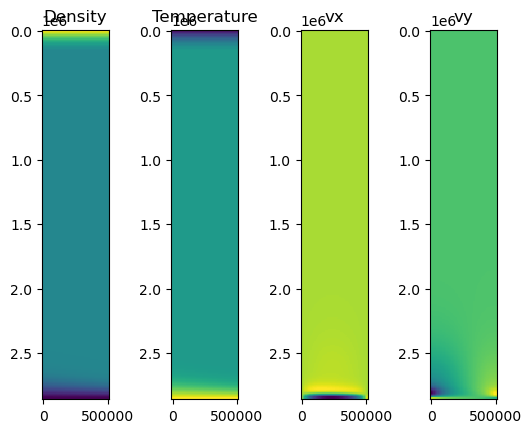

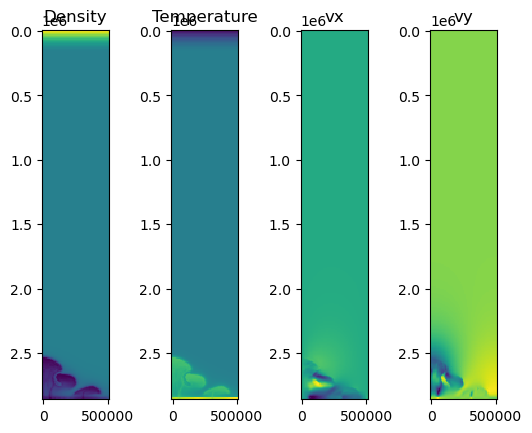

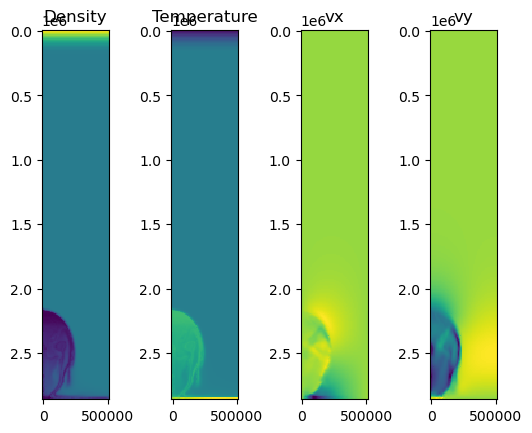

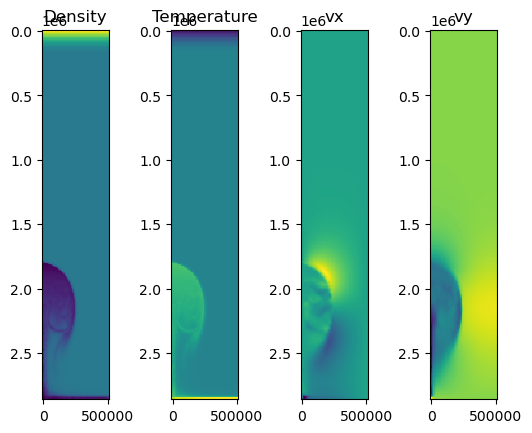

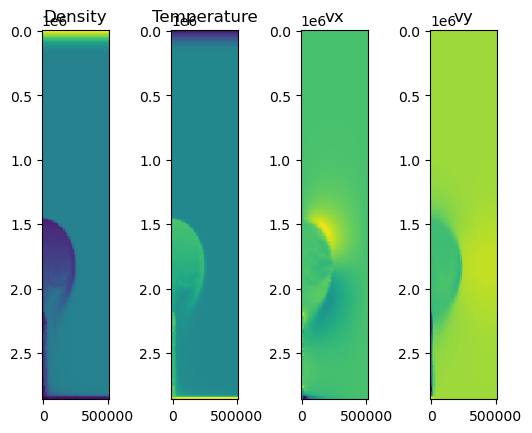

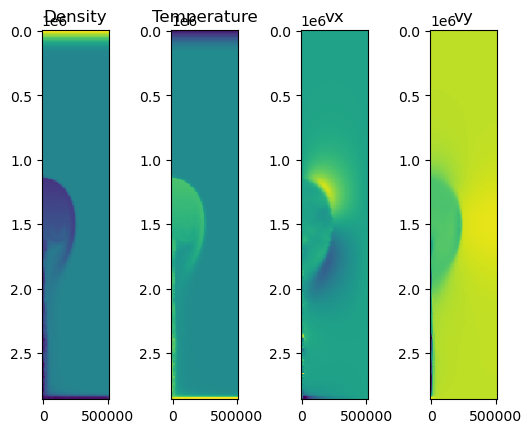

In [23]:
function plume_model(nstep::Int64)
# nstep=1
    nx = 51
    ny = 285
    W = 5e5
    H = 2.850e6
    gx = 0.0
    gy = 10.0

    Tbcval = [0.0,0.0,273.0,2500.0+273.0]
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    
    markx = 10
    marky = 10
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 5e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","Cp","T","rho","eta","Hr"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);

    time = 0.0
    iout=0
    last_plot = 0.0
    rho_c = nothing
    dt = 1e10

      local rho_c
      local rho_vx
      local rho_vy
      local alpha
      local Hr
      local Cp_c
      local eta_s
      local eta_n
      local eta_vx
      local eta_vy
      local vx,vy
      local vxc=nothing
      local vyc=nothing
      local T
      local dt
      local dTmax
      local dTemp
      local Tnew=nothing
      local Tlast

     output_dir = "plume"
     itime=1
     for itime in 1:nstep
        update_marker_properties!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_basic_node(markers,grid,["eta",]);
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new = marker_to_cell_center(markers,grid,["rho","Cp","alpha","eta","T","Hr"])
        # 1c. Vx and Vy nodes:
        rho_vx_new,eta_vx_new = marker_to_stag(markers,grid,["rho","eta"],"vx")
        rho_vy_new,eta_vy_new = marker_to_stag(markers,grid,["rho","eta"],"vy")
        
        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
            replace_nan!(eta_vx,eta_vx_new)
            replace_nan!(eta_vy,eta_vy_new)
        end
        # Copy field data 
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        eta_vx = copy(eta_vx_new)
        eta_vy = copy(eta_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)

        Tlast = ghost_temperature_center(grid,Tlast,Tbcval)
        # 2. Assemble and solve the stokes equations
        #L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy,dt=dt)
        L,R = form_stokes_cylindrical(grid,eta_s,eta_n,eta_vx,eta_vy,rho_vx,rho_vy,bc,gx,gy)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)
    
        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)
        H = (adiabatic_heating .+ shear_heating .+ Hr).*0.0
    
        # 3. Compute the advection timestep:
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax)
        
        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer=1
        for titer=1:2# limit maximum temperature change
            # assemble and solve the energy equation
            println("Trying with timestep ",dt/3.15e7/1e6," Myr")
            L,R = assemble_energy_equation_cylindrical(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
            println("dTmax=",dTmax," dt=",dt/3.15e7/1e6)
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end
        if any(isnan.(markers.scalars[markers.scalarFields["rho"],:]))
            println("nan in density")
            break
        end
        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,dTemp,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node

        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")
#         println("dT_remaining max ",extrema(dT_remaining))
#         println("marker temperature max ",maximum(markers.scalars[markers.scalarFields["T"],:])," min ",minimum(markers.scalars[markers.scalarFields["T"],:]))
#         println("marker density max ",maximum(markers.scalars[markers.scalarFields["rho"],:])," min ",minimum(markers.scalars[markers.scalarFields["rho"],:]))

        if any(isinf.(markers.scalars[markers.scalarFields["T"],:]))
            println("Nan in marker temp")
            break
        end
        if time == 0.0 || time - last_plot >= plot_interval
            last_plot = time 
    
            plume_plots(grid,vxc,vyc,rho_c,Tnew)
    
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            println("Writing visualization fle ",name)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1
        end
        
        println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1.0/3.0)
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
     end
     return grid,markers,vx,vy,vxc,vyc,rho_c,dTemp,Tnew,Tlast,time
 end
 @time grid,markers,vx,vy,vxc,vyc,rho_c,dTemp,Tnew,Tlast,time = plume_model(2000);


Int64[]

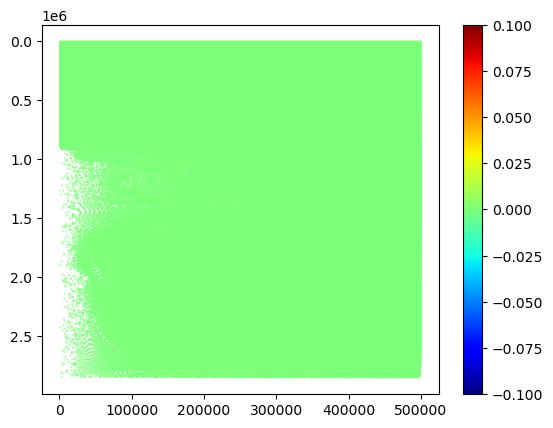

6×0 Matrix{Float64}

In [28]:
figure()
scatter(markers.x[1,:],markers.x[2,:],c=isnan.(markers.scalars[markers.scalarFields["rho"],:]),s=0.1,cmap="jet")
colorbar()
gca().invert_yaxis()
show()

ind = findall(isnan,(markers.scalars[markers.scalarFields["rho"],:]))
print(ind)
markers.scalars[:,ind]

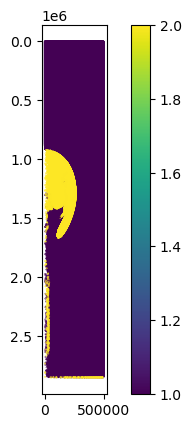

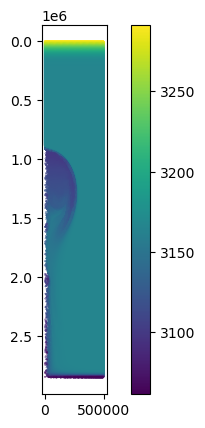

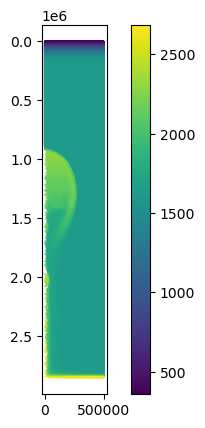

In [25]:
# figure()
# # title(print(time/3.15e7))
# # pcolor(grid.xc,grid.yc,eta_n)
# gca().invert_yaxis()
# colorbar()
# show()

figure()
scatter(markers.x[1,:],markers.x[2,:],c=(markers.integers[markers.integerFields["material"],:]),s=0.1)
gca().invert_yaxis()
gca().set_aspect("equal")
colorbar()
show()

figure()
scatter(markers.x[1,:],markers.x[2,:],c=(markers.scalars[markers.scalarFields["rho"],:]),s=0.1)
gca().invert_yaxis()
gca().set_aspect("equal")
colorbar()
show()


figure()
scatter(markers.x[1,:],markers.x[2,:],c=(markers.scalars[markers.scalarFields["T"],:]),s=0.1)
gca().invert_yaxis()
gca().set_aspect("equal")
colorbar()
show()

Creating Markers...
  0.003861 seconds (19 allocations: 39.978 MiB)
Initial condition...
  0.949655 seconds (14.31 M allocations: 219.290 MiB, 7.51% gc time)
Trying with timestep 0.024006835227809487 Myr
dTmax=0.27118137708424683 dt=0.024006835227809487
Writing visualization fle plume/viz.0000.vtr
Min/Max velocity: -3.4725423673477687e-9 1.3639906352135179e-9
Finished Step 1 time=0.024006835227809487 Myr
Trying with timestep 0.02024195774415223 Myr
dTmax=0.23498845627017317 dt=0.02024195774415223
Min/Max velocity: -5.39074770224139e-9 1.7925731328515007e-9
Finished Step 2 time=0.04424879297196171 Myr
Trying with timestep 0.016430933581115244 Myr
dTmax=0.22193466398448436 dt=0.016430933581115244
Min/Max velocity: -8.665380648337316e-9 2.558701744327173e-9
Finished Step 3 time=0.06067972655307696 Myr
Trying with timestep 0.011036117134378352 Myr
dTmax=0.17649158069571058 dt=0.011036117134378352
Min/Max velocity: -1.4433433951472929e-8 4.329367131122006e-9
Finished Step 4 time=0.071715843

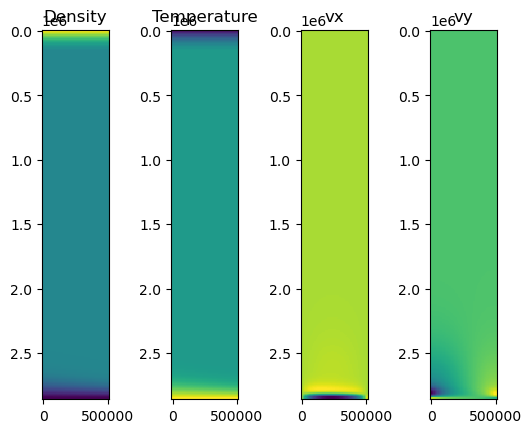

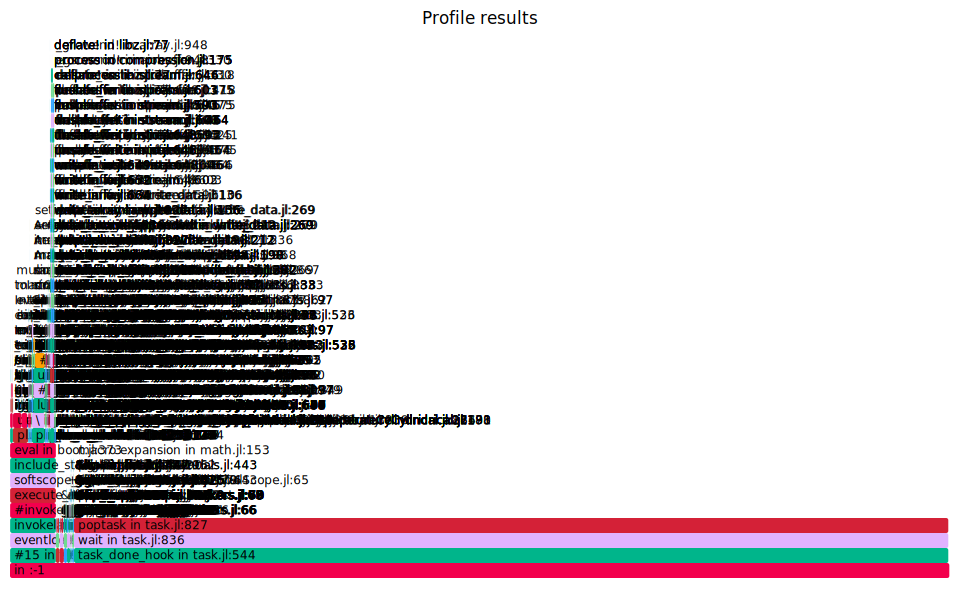

In [29]:
# Optionally, run a few steps with the profiler
using ProfileSVG
@profview plume_model(10)

In [27]:
minimum(markers.scalars[markers.scalarFields["T"],:])

357.1403392702654